In [1]:
from system import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import numpy as np
import pandas as pd
import random
import math
from tqdm import tqdm

/home/aaruran/miniconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            del self.memory[0]

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
sns.set()

In [11]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            del self.memory[0]

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

STATE_DIM = len(TradingEnv().reset())
#     print(f"STATE_DIM = {STATE_DIM}")
EMBED_DIM = 50  # from the dimensionality-reduced fastText model
HIDDEN_LAYER = 70  # NN hidden layer size
ACTION_DIM = 3

# EPISODES = 2000  # number of episodes
# EPS_START = 0.9  # e-greedy threshold start value
# EPS_END = 0.05  # e-greedy threshold end value
# EPS_DECAY = 200  # e-greedy threshold decay
# # GAMMA = 0.99  # Q-learning discount factor
# LR = 0.001  # NN optimizer learning rate
# HIDDEN_LAYER = 128  # NN hidden layer size
# BATCH_SIZE = 16  # Q-learning batch size
# TARGET_UPDATE = 100  # frequency of target update
# BUFFER_SIZE = 100  # capacity of the replay buffer

# if gpu is to be used
# use_cuda = torch.cuda.is_available()
use_cuda = False
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor


if use_cuda:
    print("GPU found and in use")
else:
    print("No GPU will be used")


class QNetwork(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(STATE_DIM, HIDDEN_LAYER)
        self.l2 = nn.Linear(HIDDEN_LAYER, HIDDEN_LAYER)
        self.l3 = nn.Linear(HIDDEN_LAYER, ACTION_DIM)

    def forward(self, x):
        """
            Computes the estimated Q-values for a given batch x
        """
        assert not torch.isnan(x).any(), f"NaN in input {x}"
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x

    def sample_from_softmax_policy(self, batch_state):
        batch_q_values = self.forward(batch_state)
        batch_pi = F.softmax(batch_q_values, dim=1)
        batch_size = batch_pi.shape[0]
        batch_actions = torch.empty(batch_size, 1)
        for i in range(batch_size):
            pi = batch_pi[i, :]
            dist = torch.distributions.Categorical(pi)
            # Subtract 1, so batch_actions is in {-1, 0, 1}
            batch_actions[i, 0] = dist.sample().view(1, 1) - 1
        if use_cuda:
            batch_actions = batch_actions.to(batch_state.get_device())
        return batch_actions.long()


class BaseAgent:
#     EPISODES = 2000  # number of episodes
    
    LR = 0.001  # NN optimizer learning rate
    
    BATCH_SIZE = 16  # Q-learning batch size
    TARGET_UPDATE = 100  # frequency of target update
    BUFFER_SIZE = 100  # capacity of the replay buffer

    def __init__(self, gamma=0.8):
        assert 0 < gamma < 1, f"Invalid gamma: {gamma}"
        sns.set()
        self.gamma = gamma
        self.memory = ReplayMemory(self.BUFFER_SIZE)
        self.history = pd.DataFrame()
#         self.rewards_history = []
        self.name = ""
        self.steps_done = 0
        with open("filtered_tickers.txt", "r") as src:
            self.filtered_tickers = src.read().split("\n")

    def run_episode(self, environment):
        """
            Takes an env, and trains the agent until the environment
            reaches a terminal state (ie the training window is complete).
            Must return environment.close()
        """
        raise NotImplementedError()

    def plot_cumulative_discounted_rewards(self):
        rl_data = self.history
        rl_data["discount_factor"] = np.power(self.gamma, rl_data.episode - 1)
        rl_data["discounted_future_reward"] = (
            rl_data["discount_factor"] * rl_data["rewards"]
        )
        rl_data = rl_data[["episode", "discounted_future_reward"]]
        rl_data = rl_data.groupby("episode").sum()
        #         rl_plot = sns.lineplot(data=rl_data, legend=False)
        title = "Cumulative Discounted Rewards over Episodes"
        if len(self.name):
            title = f'Cumulative Discounted Reward for {self.name}'
            
        rl_data.plot(legend=False, title=title)
        plt.ylabel("Cumulative Discounted Reward")
        if len(self.name):
            filename = f'plots/rewards-{self.name}.png'
            plt.savefig(filename)
        plt.show()

    def convert_action(self, action):
        assert action in [0,1,2], f'Invalid action: {action}'
        position = action - 1
        #         assert position in [-1,0,1]
        return position.item()

    def train(self, env_mode="train", num_tickers=20, num_episodes=5):
        """
            Trains the agent for num_episodes episodes, looping over the approved
            list of tickers (filtered by num_tickers). This is a convenience function.
        """
        num_tickers = min(num_tickers, len(self.filtered_tickers))
        if num_tickers == np.Inf:
            num_tickers = len(self.filtered_tickers)
        self.history = pd.DataFrame()
        for i in tqdm(range(num_episodes)):
            ticker = self.filtered_tickers[i % num_tickers]
            env = TradingEnv(ticker=ticker, mode=env_mode)
            history = self.run_episode(env)
            history["ticker"] = ticker
            history["episode"] = i + 1
            self.history = pd.concat((self.history, history))
        self.history = self.history.reset_index("Date", drop=True)
#         self.plot_returns(num_tickers)
#         self.plot_cumulative_discounted_rewards()

    def plot_returns(self, ticker):
        h = self.history
        roi_data = h[h.ticker == ticker][["date", "episode", "returns"]]
        plt.title(f"Returns for {ticker}")
        roi_plot = sns.lineplot(data=h, x="date", y="returns", hue="episode")
        roi_plot.set_xticklabels(roi_plot.get_xticklabels(), rotation=45)


No GPU will be used


In [12]:
class DQN(BaseAgent):
    EPS_START = 0.9  # e-greedy threshold start value
    EPS_END = 0.05  # e-greedy threshold end value
    EPS_DECAY = 200  # e-greedy threshold decay
    LR = 0.001  # NN optimizer learning rate

    def __init__(self):
        super().__init__()
        self.model = QNetwork()
        self.target = QNetwork()
        if use_cuda:
            self.model.cuda()
            self.target.cuda()
        self.name = "Deep Q-Network"
        self.optimizer = optim.SGD(self.model.parameters(), self.LR)

    def select_epsilon_greedy_action(self, state):
        sample = random.random()
        eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * math.exp(
            -1.0 * self.steps_done / self.EPS_DECAY
        )
        self.steps_done += 1
        greedy_action = None
        with torch.no_grad():
            greedy_action = self.model(state).data.argmax(dim=1).view(1, 1)

        random_action = LongTensor([[random.randrange(ACTION_DIM)]])
        assert (
            greedy_action.shape == random_action.shape
        ), f"Incorrect sampling techinque {greedy_action.shape, random_action.shape}"
        if sample > eps_threshold:
            return greedy_action
        else:
            return random_action

    def run_episode(self, environment):
        state = environment.reset()
        steps = 0
        action = None
        while True:
            state_tensor = FloatTensor([state])
            action = self.select_epsilon_greedy_action(state_tensor)
            position = self.convert_action(action)
            next_state, reward, done, _ = environment.step(position)

            self.memory.push(
                (
                    FloatTensor([state]),
                    action,  # action is already a tensor
                    FloatTensor([next_state]),
                    FloatTensor([reward]),
                    FloatTensor([int(done)]),
                )
            )

            self.learn()
            if self.steps_done % self.TARGET_UPDATE == 0:
                self.target.load_state_dict(self.model.state_dict())

            state = next_state
            steps += 1
            if done:
                break
        history = environment.close()
        return history

    def max_next_q_values(self, batch_next_state):
        # expected Q values are estimated from actions which gives maximum Q value
        return self.target(batch_next_state).detach().max(1)[0]

    def learn(self):
        if len(self.memory) <= self.BATCH_SIZE:
            return
        # random transition batch is taken from experience replay memory
        transitions = self.memory.sample(self.BATCH_SIZE)
        batch_state, batch_action, batch_next_state, batch_reward, batch_done = zip(
            *transitions
        )
        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))
        batch_done = Variable(torch.cat(batch_done))

        # current Q values are estimated by NN for all actions
        current_q_values = self.model(batch_state).gather(1, batch_action).squeeze()
        expected_future_rewards = self.max_next_q_values(batch_next_state)

        expected_q_values = batch_reward + (self.gamma * expected_future_rewards) * (
            1 - batch_done
        )

        # loss is measured from error between current and newly expected Q values
        loss = F.mse_loss(current_q_values, expected_q_values)

        # backpropagation of loss to QNetwork
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


In [16]:
dqn_agent = DQN()
dqn_agent.train(num_tickers=len(dqn_agent.filtered_tickers), 
                num_episodes=len(dqn_agent.filtered_tickers) * 1)

100%|██████████| 429/429 [10:59<00:00,  1.54s/it]


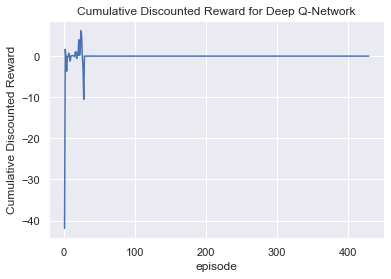

In [17]:
dqn_agent.plot_cumulative_discounted_rewards()

In [ ]:
# plt.ylim(-1000,1000)
dqn_agent.plot_returns('MMM')

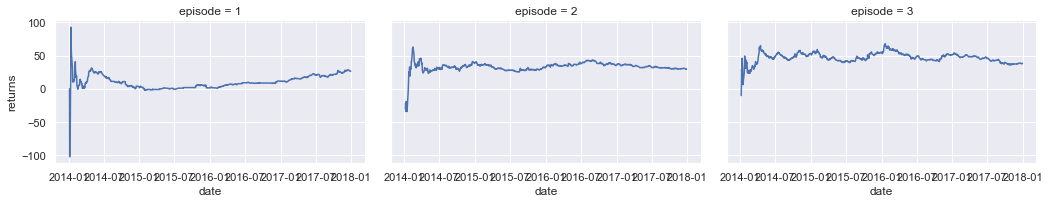

In [13]:
q = sns.FacetGrid(dqn_agent.history, col='episode', col_wrap=4, aspect=1.61)
q.map(sns.lineplot, 'date', 'returns')

# LongOnly Agent

In [19]:
class LongOnlyAgent(BaseAgent):
    def __init__(self):
        super().__init__()
        self.name = "Long-Only Strategy"

    def run_episode(self, environment):
        state = environment.reset()
        steps = 0
        position = 1
        while True:
            _, r, done, __ = environment.step(position)
            self.steps_done += 1
            steps += 1
            if done:
                break
        self.history.append(environment.rewards_list)
        return environment.close()


In [20]:
long_agent = LongOnlyAgent()

In [23]:
long_agent.train(num_tickers=len(long_agent.filtered_tickers), 
                num_episodes=len(long_agent.filtered_tickers) * 1)

100%|██████████| 429/429 [07:01<00:00,  1.02it/s]


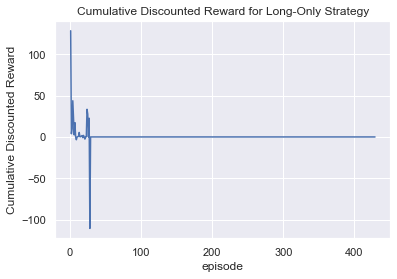

In [24]:
long_agent.plot_cumulative_discounted_rewards()

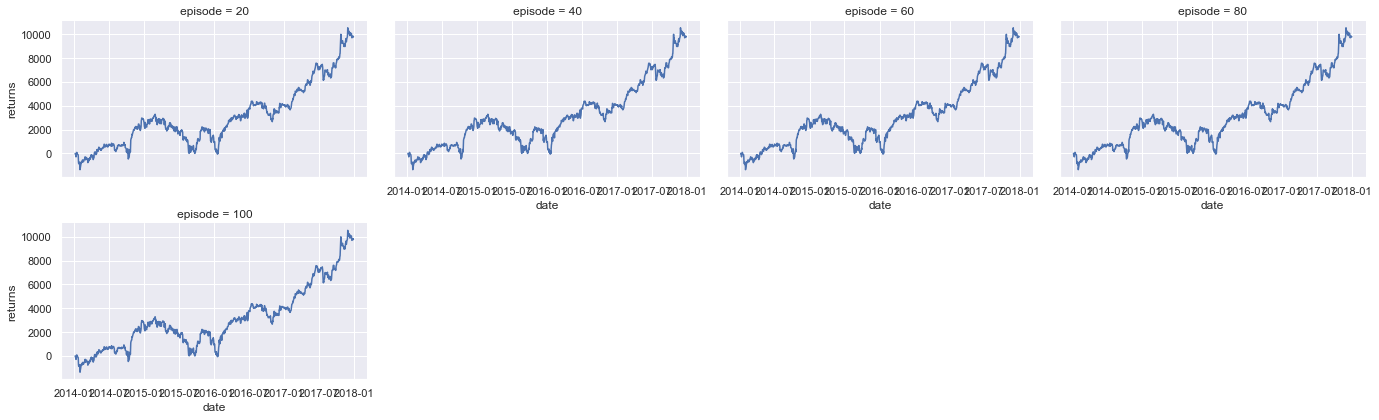

In [21]:
q = sns.FacetGrid(long_agent.history[long_agent.history.episode % 20 == 0], col='episode', col_wrap=4, aspect=1.61)
q.map(sns.lineplot, 'date', 'returns')

# Policy Network

In [31]:
class PolicyNetwork(nn.Module):
    # for Policy-Gradient methods, e.g. actor-only and actor-critic methods
    def __init__(self):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(STATE_DIM, HIDDEN_LAYER)
        self.l2 = nn.Linear(HIDDEN_LAYER, ACTION_DIM)
#         self.l2 = nn.Linear(HIDDEN_LAYER, HIDDEN_LAYER)
#         self.l3 = nn.Linear(HIDDEN_LAYER, ACTION_DIM)

    def forward(self, x, logits=True):
        """
            returns the logits of the probability
        """
        assert not torch.isnan(x).any(), f"NaN in input {x}"
        x = F.relu(self.l1(x))
        x = self.l2(x)
#         x = F.relu(self.l2(x))
#         x = self.l3(x)
        if not logits:
            x = torch.softmax(x, dim=1)
        return x

    def sample_from_softmax_policy(self, batch_state):
        batch_logits = self.forward(batch_state).detach()
        assert not torch.isnan(batch_logits).any(), f"NaN in policy logits {batch_logits}"
        batch_size = batch_logits.shape[0]
        actions = torch.empty(batch_size, 1)
        for i in range(batch_size):
            logits = batch_logits[i, :]
            dist = torch.distributions.Categorical(logits=logits)
            actions[i, 0] = dist.sample().view(1, 1)
        if use_cuda:
            actions = actions.to(batch_state.get_device())
        return actions.long()

# A2C

In [32]:
class A2C(BaseAgent):
    def __init__(self):
        super().__init__()
        self.name = "A2C"
        self.policy = PolicyNetwork()
        self.model = QNetwork()
        if use_cuda:
            self.policy.cuda()
            self.model.cuda()

        self.optimizer = optim.SGD(
            chain(self.model.parameters(), self.policy.parameters()), self.LR
        )

    def run_episode(self, environment):
        state = environment.reset()
        self.steps_done = 0
        action = None
        while True:
            state_tensor = FloatTensor([state])
            action = self.policy.sample_from_softmax_policy(state_tensor)
            position = self.convert_action(action)
            next_state, reward, done, _ = environment.step(position)
            next_state_tensor = FloatTensor([next_state])
            self.learn(state_tensor, action, next_state_tensor, reward)
            state = next_state
            self.steps_done += 1
            if done:
                break
        history = environment.close()
        return history

    def learn(self, state_tensor, action, next_state_tensor, reward):
        n = self.steps_done
        q_values = self.model(state_tensor)
        q_values_detached = q_values.detach()
        pi = self.policy(state_tensor, logits=False)
        with torch.no_grad():
            pi_detached = pi.detach()
            q = q_values_detached.gather(1, action)
            future_q = reward + self.gamma * self.model(next_state_tensor).max(dim=1)[0].detach()
            delta = future_q - q

            A = future_q - torch.dot(
                q_values_detached.squeeze(0), pi_detached.squeeze(0)
            )

        q_loss = delta * q_values.gather(1, action)
        pi_a = pi.gather(1, action)
        policy_loss = A * torch.log(pi_a)

        loss = (self.gamma ** n) * (policy_loss + q_loss)

        # backpropagation of loss to QNetwork and PolicyNetwork
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


In [33]:
a2c_agent = A2C()
a2c_agent.train(num_tickers=len(a2c_agent.filtered_tickers),
                num_episodes=len(a2c_agent.filtered_tickers))

 53%|█████▎    | 227/429 [04:45<04:14,  1.26s/it]


AssertionError: NaN in policy logits tensor([[nan, nan, nan]])

In [ ]:
%debug

> <ipython-input-31-5e02bc9819d4>(25)sample_from_softmax_policy()
     23     def sample_from_softmax_policy(self, batch_state):
     24         batch_logits = self.forward(batch_state).detach()
---> 25         assert not torch.isnan(batch_logits).any(), f"NaN in policy logits {batch_logits}"
     26         batch_size = batch_logits.shape[0]
     27         actions = torch.empty(batch_size, 1)



ipdb>  batch_state


tensor([[-3.7403e+00, -1.4508e-02,  7.5235e-03, -1.9217e-01, -1.0579e-03,
         -3.7258e+00, -3.0816e-03,  8.2692e-03, -3.8359e-01, -1.0176e-03,
         -3.7227e+00, -2.0492e-03,  6.9671e-03, -2.9670e-01, -8.9198e-04,
         -3.7207e+00, -2.0449e-03,  7.5712e-03, -2.8458e-01, -7.8310e-04,
         -3.7186e+00,  1.2333e-02,  8.2900e-03, -1.1215e-01,  4.5811e-04,
         -3.7310e+00, -1.0288e-02,  7.8592e-03, -1.3689e-01, -3.7921e-04,
         -3.7207e+00, -1.3218e-02,  8.3941e-03, -2.1376e-01, -1.2646e-03,
         -3.7075e+00,  2.7651e-02,  1.0527e-02,  1.3034e-02,  1.3163e-03,
         -3.7351e+00,  0.0000e+00,  1.0594e-02, -1.3129e-02,  1.1176e-03,
         -3.7351e+00, -2.4617e-02,  1.0495e-02, -1.6389e-01, -1.0145e-03,
         -3.7105e+00, -2.0243e-03,  1.1146e-02, -1.3589e-01, -8.7119e-04,
         -3.7085e+00,  1.4257e-02,  1.2086e-02, -1.1825e-01,  5.4981e-04,
         -3.7227e+00,  3.4432e-02,  1.0808e-02,  8.3560e-02,  3.2663e-03,
         -3.7572e+00,  8.5288e-03,  1.

In [ ]:
a2c_agent.plot_cumulative_discounted_rewards()

In [30]:
a2c_agent.filtered_tickers[127]

'CCI'

In [ ]:
a2c_agent

In [55]:
tickers = a2c_agent.filtered_tickers

In [58]:
e.data[e.df_index:]

,x,std,sharpe,q
Date,,,,
2015-02-19,0.0,5.653439e-10,NaN,-0.088084
2015-02-20,0.0,5.653439e-10,NaN,-0.079195
2015-02-23,0.0,5.653439e-10,NaN,-0.071327
2015-02-24,0.0,5.653439e-10,NaN,-0.064351
2015-02-25,0.0,5.653439e-10,NaN,-0.058151
...,...,...,...,...
2017-12-29,0.0,1.636465e-02,-0.377964,0.033018
2018-01-02,0.0,1.636465e-02,-0.377964,0.050515
2018-01-03,0.0,1.636465e-02,-0.377964,0.063648


In [29]:
e = TradingEnv('ABBV')
e.data[e.df_initial_index-5:]

,x,std,sharpe,q
Date,,,,
2013-12-27,-0.008715,0.014263,0.246328,0.915886
2013-12-30,0.003780,0.007296,-0.066857,0.893301
2013-12-31,0.015842,0.009591,0.172775,0.849471
2014-01-02,-0.006137,0.010041,0.075806,0.739241
2014-01-03,0.037204,0.017153,0.317064,0.669980
...,...,...,...,...
2017-12-29,-0.017426,0.009047,-0.161914,0.873943
2018-01-02,-0.015528,0.010490,-0.283490,0.896064
2018-01-03,0.005719,0.010987,-0.155026,1.026033


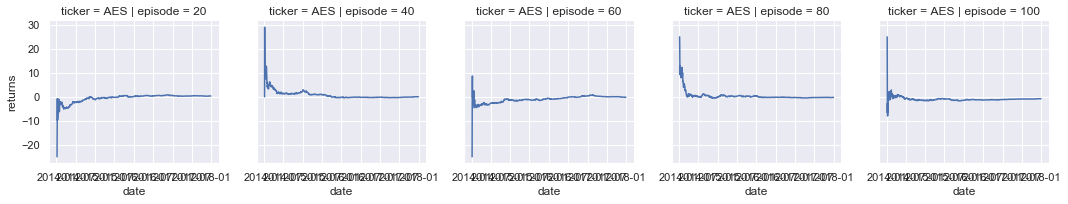

In [34]:
h = a2c_agent.history
q = sns.FacetGrid(h[h.episode % 20 == 0], col='episode',row='ticker')
q.map(sns.lineplot, 'date', 'returns')

In [42]:
e = TradingEnv('AAPL')
# s0 = FloatTensor([e.reset()])

In [45]:
a2c_agent = A2C()
%lprun -f a2c_agent.learn [a2c_agent.run_episode(e) for _ in range(3)]

Timer unit: 1e-06 s

Total time: 5.15225 s
File: <ipython-input-37-bcce39958266>
Function: learn at line 31

Line #      Hits         Time  Per Hit   % Time  Line Contents
    31                                               def learn(self, state_tensor, action, next_state_tensor, reward):
    32      3015       3336.0      1.1      0.1          n = self.steps_done
    33      3015     664178.0    220.3     12.9          q_values = self.model(state_tensor)
    34      3015     661365.0    219.4     12.8          pi = self.policy(state_tensor)
    35      3015      10079.0      3.3      0.2          with torch.no_grad():
    36      3015       5440.0      1.8      0.1              q_values_detached = q_values.detach()
    37      3015       3609.0      1.2      0.1              pi_detached = pi.detach()
    38      3015      38354.0     12.7      0.7              q = q_values_detached.gather(1, action)
    39      3015     705073.0    233.9     13.7              future_q = reward + self

In [46]:
%lprun -f a2c_agent.run_episode [a2c_agent.run_episode(e) for _ in range(3)]

Timer unit: 1e-06 s

Total time: 9.39259 s
File: <ipython-input-37-bcce39958266>
Function: run_episode at line 12

Line #      Hits         Time  Per Hit   % Time  Line Contents
    12                                               def run_episode(self, environment):
    13         3       3729.0   1243.0      0.0          state = environment.reset()
    14         3          5.0      1.7      0.0          self.steps_done = 0
    15         3          4.0      1.3      0.0          action = None
    16         3          2.0      0.7      0.0          while True:
    17      3015      88921.0     29.5      0.9              state_tensor = FloatTensor([state])
    18      3015    1302285.0    431.9     13.9              action = self.policy.sample_from_softmax_policy(state_tensor)
    19      3015      96108.0     31.9      1.0              position = self.convert_action(action)
    20      3015    2569393.0    852.2     27.4              next_state, reward, done, _ = environment.step(pos

In [ ]:
a2c_agent.policy

 # Model-based (using Reddit Comments)

In [ ]:
class ModelBasedAgent(BaseAgent):
    def __init__(self):
        super().__init__()